In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline

In [2]:
np.random.seed(42)
n_samples = 5000

returns = np.random.normal(0, 0.02, n_samples + 21)

# Create lagged features (20 lags)
X = np.zeros((n_samples, 20))
for i in range(20):
    X[:, i] = returns[20-i:n_samples+20-i]

y = returns[21:n_samples+21].reshape(-1, 1)

print(f"Dataset ready: {X.shape[0]} samples, {X.shape[1]} lag features")
print("X and y now perfectly aligned")

Dataset ready: 5000 samples, 20 lag features
X and y now perfectly aligned


In [3]:
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

print(f"Train: {X_train_scaled.shape[0]} samples | Test: {X_test_scaled.shape[0]} samples")

Train: 4000 samples | Test: 1000 samples


In [4]:
class NeuralNetwork:
    def __init__(self, input_size, h1=64, h2=32):
        # Xavier initialization
        self.W1 = np.random.randn(input_size, h1) * np.sqrt(2.0 / input_size)
        self.b1 = np.zeros((1, h1))
        self.W2 = np.random.randn(h1, h2) * np.sqrt(2.0 / h1)
        self.b2 = np.zeros((1, h2))
        self.W3 = np.random.randn(h2, 1) * np.sqrt(2.0 / h2)
        self.b3 = np.zeros((1, 1))
    
    def relu(self, x):
        return np.maximum(0, x)
    
    def relu_deriv(self, x):
        return (x > 0).astype(float)
    
    def forward(self, X):
        self.z1 = X @ self.W1 + self.b1
        self.a1 = self.relu(self.z1)
        self.z2 = self.a1 @ self.W2 + self.b2
        self.a2 = self.relu(self.z2)
        self.output = self.a2 @ self.W3 + self.b3
        return self.output
    
    def train(self, X, y, epochs=3000, lr=0.01, momentum=0.9):
        vW1 = np.zeros_like(self.W1)
        vb1 = np.zeros_like(self.b1)
        vW2 = np.zeros_like(self.W2)
        vb2 = np.zeros_like(self.b2)
        vW3 = np.zeros_like(self.W3)
        vb3 = np.zeros_like(self.b3)
        
        losses = []
        for i in range(epochs):
            output = self.forward(X)
            loss = np.mean((output - y)**2)
            losses.append(loss)
            
            m = X.shape[0]
            dz3 = 2 * (output - y) / m
            dW3 = self.a2.T @ dz3
            db3 = np.sum(dz3, axis=0, keepdims=True)
            
            da2 = dz3 @ self.W3.T
            dz2 = da2 * self.relu_deriv(self.z2)
            dW2 = self.a1.T @ dz2
            db2 = np.sum(dz2, axis=0, keepdims=True)
            
            da1 = dz2 @ self.W2.T
            dz1 = da1 * self.relu_deriv(self.z1)
            dW1 = X.T @ dz1
            db1 = np.sum(dz1, axis=0, keepdims=True)
            
            vW3 = momentum * vW3 - lr * dW3
            vb3 = momentum * vb3 - lr * db3
            vW2 = momentum * vW2 - lr * dW2
            vb2 = momentum * vb2 - lr * db2
            vW1 = momentum * vW1 - lr * dW1
            vb1 = momentum * vb1 - lr * db1
            
            self.W3 += vW3
            self.b3 += vb3
            self.W2 += vW2
            self.b2 += vb2
            self.W1 += vW1
            self.b1 += vb1
            
            if i % 500 == 0:
                print(f"Epoch {i}: MSE = {loss:.6f}")
        
        return losses

nn = NeuralNetwork(input_size=X_train_scaled.shape[1])
print("Network initialized")

Network initialized


Starting training...
Epoch 0: MSE = 3.068305
Epoch 500: MSE = 0.854902
Epoch 1000: MSE = 0.585784
Epoch 1500: MSE = 0.399226
Epoch 2000: MSE = 0.298336
Epoch 2500: MSE = 0.236642


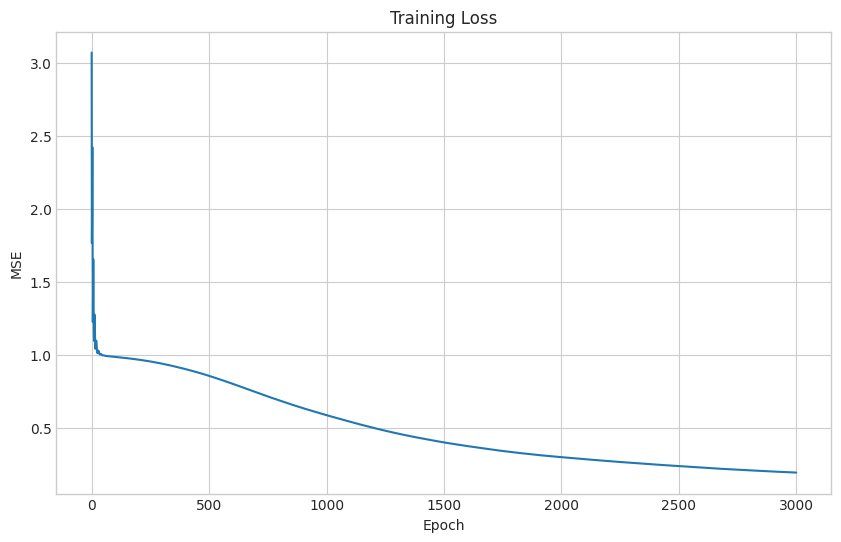

In [5]:
print("Starting training...")
losses = nn.train(X_train_scaled, y_train_scaled, epochs=3000, lr=0.01, momentum=0.9)

plt.figure(figsize=(10,6))
plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.grid(True)
plt.show()

Test R²: -1.2357
Test RMSE: 0.029660


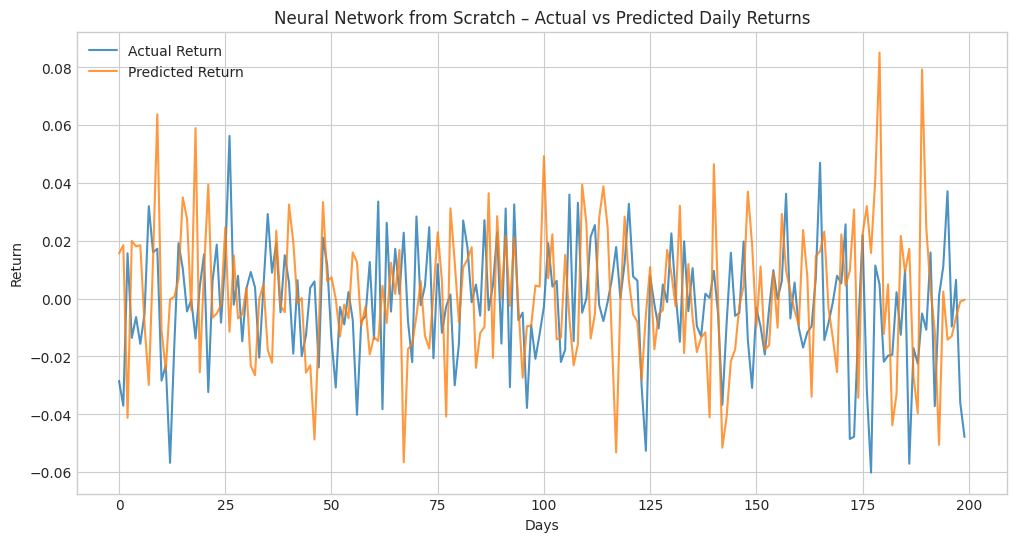


Project 4 complete
Neural Network built using only NumPy


In [6]:
train_pred_scaled = nn.forward(X_train_scaled)
test_pred_scaled = nn.forward(X_test_scaled)

train_pred = scaler_y.inverse_transform(train_pred_scaled)
test_pred = scaler_y.inverse_transform(test_pred_scaled)

test_r2 = r2_score(y_test, test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))

print(f"Test R²: {test_r2:.4f}")
print(f"Test RMSE: {test_rmse:.6f}")

# Plot actual vs predicted
plt.figure(figsize=(12,6))
plt.plot(y_test[:200], label='Actual Return', alpha=0.8)
plt.plot(test_pred[:200], label='Predicted Return', alpha=0.8)
plt.title('Neural Network from Scratch – Actual vs Predicted Daily Returns')
plt.xlabel('Days')
plt.ylabel('Return')
plt.legend()
plt.grid(True)
plt.show()

print("\nProject 4 complete")
print("Neural Network built using only NumPy")